# CCP

> flashing interface for CCP
> For now, only support CCP on CAN via VCAN or Kvaser CAN interface

In [ ]:
#| default_exp ccp

In [ ]:
#| hide
from nbdev.showdoc import show_doc
from fastcore.test import *

In [ ]:
#| export
import os
import sys
import git
import argparse
from InquirerPy import inquirer
from InquirerPy.validator import EmptyInputValidator
from InquirerPy.base.control import Choice
from pydantic import BaseModel, Field,  ConfigDict, model_validator, conlist, conint, computed_field, confloat, ValidationError
from pydantic.functional_validators import AfterValidator
from typing import Optional, TypedDict, Union, Literal
from typing_extensions import Annotated
from enum import StrEnum
from pprint import pprint, PrettyPrinter

In [ ]:
#| export
import subprocess
from multiprocessing import Manager
from multiprocessing.managers import DictProxy
import cantools
from cantools.database import Message as MessagerTpl
from cantools.database.can.database import Database
import contextlib

In [ ]:
#| export
import pandas as pd
import numpy as np
import struct

In [ ]:
# #|export
# from candycan.data_link_socketcan import done, send_msg

In [ ]:
#| export 
from candycan.a2l import (
    list_of_strings,
    XCPCalib,
    XCPData,
    XCPConfig,
    Get_XCPCalib_From_XCPJSon,
    Generate_Init_XCPData_From_A2L,
)


'/home/n/devel/candycan'


In [ ]:
#| export
from scapy.all import (
    raw, rdpcap, wrpcap, load_contrib, hexdump,
    ls, conf, load_layer, IP, Ether, TCP
)
# Ether, TCP, hexdump, raw, rdpcap, load_contrib, conf, load_layer, 
# CANSocket, CAN, wrpcap, CCP, CRO, CONNECT, GET_SEED, UNLOCK, GET_DAQ_SIZE

In [ ]:
#| export
load_layer("can")  # CAN
conf.contribs['CANSocket'] = {'use-python-can': False}
load_contrib("cansocket") # CANSocket
load_contrib("automotive.ccp")  # CCP, CRO, CONNECT, DISCONNECT, GET_SEED, UNLOCK, GET_DAQ_SIZE

In [ ]:
#| export
pp = PrettyPrinter(indent=4, width=80, compact=True)

In [ ]:
#| export 
repo = git.Repo("./", search_parent_directories=True)  # get the Repo object of tspace
if os.path.basename(repo.working_dir) != "candycan":  # I'm in the parent repo!
    repo = repo.submodule("candycan").module()
pprint(repo.working_dir)

'/home/n/devel/candycan'


In [ ]:
#| export
def get_argparser() -> argparse.ArgumentParser:
	"""Summary
	Get argument parser for command line arguments

	Returns:
		argparse.ArgumentParser: _description_
	"""
	parser = argparse.ArgumentParser(description='XCP Processing')

	parser.add_argument(
		'--protocol',
		type=str,
		choices=['ccp', 'xcp'],
		default='ccp',
		help='Protocol to use: ccp/xcp',
	)

	parser.add_argument(
		'--download',
		default=False,
		help='Download or upload: default is download(host->target)',
		action='store_true',
	)

	parser.add_argument(
		'--diff_flashing',
		default=True,
		help='use differential flashing',
		action='store_false',
	)

	parser.add_argument(
		'--a2l', 
		type=str,
        default=repo.working_dir+'/res/VBU_AI.json',
		help='a2l json file path')
		
	parser.add_argument(
		"--node-path",
		type=str,
		default=r"/PROJECT/MODULE[]",
		help="node path to search for calibration parameters",
	)

	parser.add_argument(
		"--leaves",
		type=list_of_strings,
		default=r"TQD_trqTrqSetNormal_MAP_v, " 
				r"VBU_L045A_CWP_05_09T_AImode_CM_single, " 
				r"Lookup2D_FLOAT32_IEEE, " 
				r"Lookup2D_X_FLOAT32_IEEE, " 
				r"Scalar_FLOAT32_IEEE, " 
				r"TQD_vVehSpd, "
				r"TQD_vSgndSpd_MAP_y, "
				r"TQD_pctAccPedPosFlt, "
				r"TQD_pctAccPdl_MAP_x",
			help="leaf nodes to search for",
	)

	parser.add_argument(
		'--channel', 
		type=int,
		default=3,
		help='CAN channel for flashing')
		
	parser.add_argument(
		'--download_id', 
		type=int,
		default=630,
		help='CAN message ID for downloading')
		
	parser.add_argument(
		'--upload_id', 
		type=int,
		default=631,
		help='CAN message ID for downloading')
		
	parser.add_argument(
		'--input', 
		type=str,
        default=repo.working_dir+'/res/download.json',
		help='Input file path')
	
	parser.add_argument(
		'--output', 
		type=str, 
        default=repo.working_dir+'/res/output.json',
		help='Output file path')
	return parser

In [ ]:
show_doc(get_argparser)

---

[source](https://github.com/Binjian/candycan/blob/main/candycan/xcp.py#L50){target="_blank" style="float:right; font-size:smaller"}

### get_argparser

>      get_argparser ()

Summary
Get argument parser for command line arguments

Returns:
        argparse.ArgumentParser: _description_

In [ ]:
parser = get_argparser()
args = parser.parse_args(
    args=[
        '--protocol', 'xcp',
        '--download',
        '--a2l', repo.working_dir+'/res/VBU_AI.json',
        '--node-path', r'/PROJECT/MODULE[]',
        '--leaves', r'TQD_trqTrqSetNormal_MAP_v, VBU_L045A_CWP_05_09T_AImode_CM_single, Lookup2D_FLOAT32_IEEE, Lookup2D_X_FLOAT32_IEEE, Scalar_FLOAT32_IEEE, TQD_vVehSpd, TQD_vSgndSpd_MAP_y, TQD_pctAccPedPosFlt, TQD_pctAccPdl_MAP_x',
        '--channel', '3',
        '--download_id', '630',
        '--upload_id', '631',
        '--input', repo.working_dir+'/res/download.json',
        '--output', repo.working_dir+'/res/output.json',
    ]
)

In [ ]:
args.download_id, args.channel, args.upload_id

(630, 3, 631)

In [ ]:
xcp_calib_from_xcpjson = Get_XCPCalib_From_XCPJSon(args.input)
xcp_calib_from_xcpjson

XCPCalib(config=XCPConfig(channel=3, download_can_id=630, upload_can_id=631), data=[{   'address': '7000aa2a',
    'dim': [14, 17],
    'name': 'TQD_trqTrqSetNormal_MAP_v',
    'type_size': 4,
    'value': '0000000025...344',
    'value_array_view': array([[    0.   ,  1135.317,  1135.317, ...,  4436.   ,  4436.   ,
         4436.   ],
       [    0.   ,   148.09 ,   148.09 , ...,  4436.   ,  4436.   ,
         4436.   ],
       [-1338.534,  -833.344,  -328.155, ...,  4436.   ,  4436.   ,
         4436.   ],
       ...,
       [-1316.842, -1086.408,  -855.974, ...,  2034.368,  2034.368,
         2034.368],
       [-1141.171,  -926.042,  -710.912, ...,  1859.521,  1859.521,
         1859.521],
       [ -286.008,  -135.973,    14.062, ...,  1690.249,  1690.249,
         1690.249]], dtype=float32),
    'value_length': 4,
    'value_type': 'FLOAT32_IEEE'}])

In [ ]:

xcp_data = Generate_Init_XCPData_From_A2L(
    a2l=args.a2l, keys=args.leaves, node_path=args.node_path
)

#  address from xcp data file should align with the address from xcp calib file
test_eq(xcp_data.address, xcp_calib_from_xcpjson.data[0].address)

# validate the model
try:
    XCPData.model_validate(xcp_data)
except ValidationError as exc:
    print(exc)

{   'address': '7000aa2a',
    'dim': [14, 17],
    'name': 'TQD_trqTrqSetNormal_MAP_v',
    'type_size': 4,
    'value': '0000000000...000',
    'value_array_view': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
    'value_length': 4,
    'value_type': 'FLOAT32_IEEE'}

In [ ]:
# type(args.channel), type(args.download_id), args.upload_id, args.download, args.diff_flashing

In [ ]:
xcp_data.value = xcp_calib_from_xcpjson.data[0].value
pprint(xcp_data)
xcp_data.value_array_view[0,2], xcp_data.value_array_view[2,0]

{   'address': '7000aa2a',
    'dim': [14, 17],
    'name': 'TQD_trqTrqSetNormal_MAP_v',
    'type_size': 4,
    'value': '0000000025...344',
    'value_array_view': array([[    0.   ,  1135.317,  1135.317, ...,  4436.   ,  4436.   ,
         4436.   ],
       [    0.   ,   148.09 ,   148.09 , ...,  4436.   ,  4436.   ,
         4436.   ],
       [-1338.534,  -833.344,  -328.155, ...,  4436.   ,  4436.   ,
         4436.   ],
       ...,
       [-1316.842, -1086.408,  -855.974, ...,  2034.368,  2034.368,
         2034.368],
       [-1141.171,  -926.042,  -710.912, ...,  1859.521,  1859.521,
         1859.521],
       [ -286.008,  -135.973,    14.062, ...,  1690.249,  1690.249,
         1690.249]], dtype=float32),
    'value_length': 4,
    'value_type': 'FLOAT32_IEEE'}


(1135.317, -1338.5337)

In [ ]:

xcp_calib = XCPCalib(
    config=XCPConfig(
        channel=args.channel, download=args.download_id, upload=args.upload_id
    ),
    data=[xcp_data],
)

In [ ]:
pprint(xcp_calib)

XCPCalib(config=XCPConfig(channel=3, download_can_id=630, upload_can_id=631), data=[{   'address': '7000aa2a',
    'dim': [14, 17],
    'name': 'TQD_trqTrqSetNormal_MAP_v',
    'type_size': 4,
    'value': '0000000025...344',
    'value_array_view': array([[    0.   ,  1135.317,  1135.317, ...,  4436.   ,  4436.   ,
         4436.   ],
       [    0.   ,   148.09 ,   148.09 , ...,  4436.   ,  4436.   ,
         4436.   ],
       [-1338.534,  -833.344,  -328.155, ...,  4436.   ,  4436.   ,
         4436.   ],
       ...,
       [-1316.842, -1086.408,  -855.974, ...,  2034.368,  2034.368,
         2034.368],
       [-1141.171,  -926.042,  -710.912, ...,  1859.521,  1859.521,
         1859.521],
       [ -286.008,  -135.973,    14.062, ...,  1690.249,  1690.249,
         1690.249]], dtype=float32),
    'value_length': 4,
    'value_type': 'FLOAT32_IEEE'}])


In [ ]:
npa =  xcp_calib.data[0].value_array_view
npa.shape, npa.dtype, npa
len(xcp_calib.data[0].value_bytes), xcp_calib.data[0].value_bytes

len(npa.tobytes()), npa.tobytes()
test_eq(npa.tobytes(), xcp_calib.data[0].value_bytes)
xcp_calib.data[0].value

((14, 17),
 dtype('float32'),
 array([[    0.   ,  1135.317,  1135.317, ...,  4436.   ,  4436.   ,
          4436.   ],
        [    0.   ,   148.09 ,   148.09 , ...,  4436.   ,  4436.   ,
          4436.   ],
        [-1338.534,  -833.344,  -328.155, ...,  4436.   ,  4436.   ,
          4436.   ],
        ...,
        [-1316.842, -1086.408,  -855.974, ...,  2034.368,  2034.368,
          2034.368],
        [-1141.171,  -926.042,  -710.912, ...,  1859.521,  1859.521,
          1859.521],
        [ -286.008,  -135.973,    14.062, ...,  1690.249,  1690.249,
          1690.249]], dtype=float32))

(952,
 b'\x00\x00\x00\x00%\xea\x8dD%\xea\x8dD%\xea\x8dD%\xea\x8dD\xdb4\x95D\xb3\x1e\xb6D\x8c\x08\xd7Dd\xf2\xf7D\x1en\x0cE\x81\x1d%E\xe3\xcc=EF|VE\x85\xed\x83E\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x00\x00\x00\x00\xed\x16\x14C\xed\x16\x14CN\xba\x8dC\x1ay\x1eD\xcbL`D>\x10\x91D\x17\xfa\xb1D\xef\xe3\xd2D\xc8\xcd\xf3DF\x96\x12E\xa9E+E\x0b\xf5CE\xd0SuE\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x14Q\xa7\xc4\x0bVP\xc4\xdd\x13\xa4\xc3\xb8\x081CM\xa9\xf9CV%AD\x84|\x81D\\f\xa2D5P\xc3D\r:\xe4Di\xcc\nE\xcb{#E.+<E\xf3\x89mE\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\xff\xfc\x0f\xc5\xa4\xfc\xd0\xc4K\xff\x81\xc4\xc8\x07\xcc\xc39\xdb_Cv\xa0\tD\xf8\xd7GD\xbd\x07\x83D\x7f#\xa2D@?\xc1D\xe2\xe8\xefDBI\x0fE\x13\x9e&E\xb5GUE\xab\xf8\x81E\x00\xa0\x8aE\x00\xa0\x8aEw\x1f\r\xc5\x9fj\xda\xc4Q\x96\x9a\xc4\x07\x845\xc4\xabmW\xc3b\x9a\x93C\xeb\x8d\x18D?)SDJ\xe2\x86D\xf4/\xa4Dt$\xd0D\xf3\x18\xfcD\xb9\x06\x14E9\xfb?E\xb8\xefkE\x00\xa0\x8aE\x00\xa0\x8aEH>\t\xc5\x1d\xd0\xdc\xc4\xa9#\xa7\xc4l\xeeb\xc4\n+\xef\xc3\xdc\xc9C\xc2\x

(952,
 b'\x00\x00\x00\x00%\xea\x8dD%\xea\x8dD%\xea\x8dD%\xea\x8dD\xdb4\x95D\xb3\x1e\xb6D\x8c\x08\xd7Dd\xf2\xf7D\x1en\x0cE\x81\x1d%E\xe3\xcc=EF|VE\x85\xed\x83E\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x00\x00\x00\x00\xed\x16\x14C\xed\x16\x14CN\xba\x8dC\x1ay\x1eD\xcbL`D>\x10\x91D\x17\xfa\xb1D\xef\xe3\xd2D\xc8\xcd\xf3DF\x96\x12E\xa9E+E\x0b\xf5CE\xd0SuE\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x14Q\xa7\xc4\x0bVP\xc4\xdd\x13\xa4\xc3\xb8\x081CM\xa9\xf9CV%AD\x84|\x81D\\f\xa2D5P\xc3D\r:\xe4Di\xcc\nE\xcb{#E.+<E\xf3\x89mE\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\xff\xfc\x0f\xc5\xa4\xfc\xd0\xc4K\xff\x81\xc4\xc8\x07\xcc\xc39\xdb_Cv\xa0\tD\xf8\xd7GD\xbd\x07\x83D\x7f#\xa2D@?\xc1D\xe2\xe8\xefDBI\x0fE\x13\x9e&E\xb5GUE\xab\xf8\x81E\x00\xa0\x8aE\x00\xa0\x8aEw\x1f\r\xc5\x9fj\xda\xc4Q\x96\x9a\xc4\x07\x845\xc4\xabmW\xc3b\x9a\x93C\xeb\x8d\x18D?)SDJ\xe2\x86D\xf4/\xa4Dt$\xd0D\xf3\x18\xfcD\xb9\x06\x14E9\xfb?E\xb8\xefkE\x00\xa0\x8aE\x00\xa0\x8aEH>\t\xc5\x1d\xd0\xdc\xc4\xa9#\xa7\xc4l\xeeb\xc4\n+\xef\xc3\xdc\xc9C\xc2\x

'0000000025ea8d4425ea8d4425ea8d4425ea8d44db349544b31eb6448c08d74464f2f7441e6e0c45811d2545e3cc3d45467c564585ed834500a08a4500a08a4500a08a4500000000ed161443ed1614434eba8d431a791e44cb4c60443e10914417fab144efe3d244c8cdf34446961245a9452b450bf54345d053754500a08a4500a08a4500a08a451451a7c40b5650c4dd13a4c3b80831434da9f94356254144847c81445c66a2443550c3440d3ae44469cc0a45cb7b23452e2b3c45f3896d4500a08a4500a08a4500a08a45fffc0fc5a4fcd0c44bff81c4c807ccc339db5f4376a00944f8d74744bd0783447f23a244403fc144e2e8ef4442490f45139e2645b5475545abf8814500a08a4500a08a45771f0dc59f6adac451969ac4078435c4ab6d57c3629a9343eb8d18443f2953444ae28644f42fa4447424d044f318fc44b906144539fb3f45b8ef6b4500a08a4500a08a45483e09c51dd0dcc4a923a7c46cee62c40a2befc3dcc943c29338be43be142944e413604485898b44e1c8b4443e08de44cda303452ae32c4586225645e3617f4500a08a45735904c5aa24dac46c96abc45f107ac4e5f31cc4ac5d7fc37928ea4212c3f443ff0b3e44f76e7144b5419f44efcbc5442856ec444eb51c45873f4345c1c96945f1378345efe1fcc4bac2d3c485a3aac44f8481c434ca30c49117bdc

In [ ]:
# buffer = [i.hex() for x in npa for i in x]
# # buffer[::-1]
# len(buffer)
# buffer

In [ ]:

# buffer = npa.tobytes()

# pprint(buffer), len(buffer)
# xcp_calib.data[0].value, len(xcp_calib.data[0].value)

In [ ]:
addr = bytes('7000aa2a', 'utf-8')
a = 0x7000aa2a
a

1879091754

In [ ]:
npb = npa[::-1]
# npb
buffer = [struct.pack("<f", x) for x in np.nditer(npa)]
# buffer
len(buffer)

238

### investigate int type and type size

In [ ]:
d = xcp_calib.data[0]
add = int(d.address, base=16)
d.address, add
hex(add), type(add), sys.getsizeof(add)
struct.calcsize('h'), struct.calcsize('i'), struct.calcsize('l'), struct.calcsize('L')
type(d.address),len(d.address)

('7000aa2a', 1879091754)

('0x7000aa2a', int, 32)

(2, 4, 8, 8)

(str, 8)

In [ ]:
#| export
def npa_to_packed_buffer(a: np.ndarray) -> str:
    """ convert a numpy array to a packed string buffer for flashing
    TODO: implementation as numpy ufunc

    Args:
        a (np.ndarray): input numpy array for flashing

    Returns:
        str: packed string buffer for flashing
    """
    b = [struct.pack("<f", x).hex() for x in np.nditer(a)]
    return ''.join(b)

In [ ]:

# buffer = [struct.pack("<f", x).hex() for x in np.nditer(npa)]
# buffer[::-1]
# len(buffer)
# buffer
# data = ''.join(buffer)
data = npa_to_packed_buffer(npa)
test_eq(data, xcp_calib.data[0].value)
# data

In [ ]:
# npa.astype(np.float32).tobytes().hex()
buffer = npa.astype(np.float32).tobytes().hex()  ## == npa_to_packed_buffer(npa)
buffer, len(buffer)
test_eq(buffer, xcp_calib.data[0].value)

('0000000025ea8d4425ea8d4425ea8d4425ea8d44db349544b31eb6448c08d74464f2f7441e6e0c45811d2545e3cc3d45467c564585ed834500a08a4500a08a4500a08a4500000000ed161443ed1614434eba8d431a791e44cb4c60443e10914417fab144efe3d244c8cdf34446961245a9452b450bf54345d053754500a08a4500a08a4500a08a451451a7c40b5650c4dd13a4c3b80831434da9f94356254144847c81445c66a2443550c3440d3ae44469cc0a45cb7b23452e2b3c45f3896d4500a08a4500a08a4500a08a45fffc0fc5a4fcd0c44bff81c4c807ccc339db5f4376a00944f8d74744bd0783447f23a244403fc144e2e8ef4442490f45139e2645b5475545abf8814500a08a4500a08a45771f0dc59f6adac451969ac4078435c4ab6d57c3629a9343eb8d18443f2953444ae28644f42fa4447424d044f318fc44b906144539fb3f45b8ef6b4500a08a4500a08a45483e09c51dd0dcc4a923a7c46cee62c40a2befc3dcc943c29338be43be142944e413604485898b44e1c8b4443e08de44cda303452ae32c4586225645e3617f4500a08a45735904c5aa24dac46c96abc45f107ac4e5f31cc4ac5d7fc37928ea4212c3f443ff0b3e44f76e7144b5419f44efcbc5442856ec444eb51c45873f4345c1c96945f1378345efe1fcc4bac2d3c485a3aac44f8481c434ca30c49117bd

In [ ]:
#| export
def flash_xcp(xcp_calib: XCPCalib, data: pd.DataFrame, diff_flashing: bool=False, download: bool=True):
    """Summary
    Flash XCP data to target

    Args:
        xcp_calib (XCPCalib): XCP calibration as template, contains all the meta information except for data
        xcp_data (pd.DataFrame): input XCP data to be flashed, replace the value in xcp_calib
        diff_flashing (bool): Use differential flashing
        download (bool): Download or upload
    
    """
    
    # convert dataframe to a hex string to be flashed and assigned to XCPCalib field data
    xcp_calib.data = data.astype(np.float32).tobytes().hex()

    if download:
        if diff_flashing:
            raise NotImplementedError("Differential flashing not implemented yet")
        else:
            pass
        

    

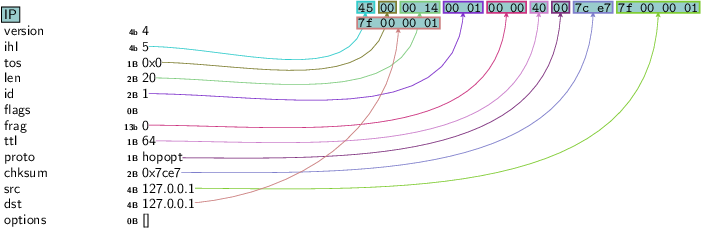

In [ ]:
pkt = IP()
pkt.canvas_dump()

In [ ]:
IP()
a = IP(dst="10.10.10.28")
a.dst
a.ttl
ls(IP)

<IP  |>

'10.10.10.28'

64

version    : BitField  (4 bits)                  = ('4')
ihl        : BitField  (4 bits)                  = ('None')
tos        : XByteField                          = ('0')
len        : ShortField                          = ('None')
id         : ShortField                          = ('1')
flags      : FlagsField                          = ('<Flag 0 ()>')
frag       : BitField  (13 bits)                 = ('0')
ttl        : ByteField                           = ('64')
proto      : ByteEnumField                       = ('0')
chksum     : XShortField                         = ('None')
src        : SourceIPField                       = ('None')
dst        : DestIPField                         = ('None')
options    : PacketListField                     = ('[]')


In [ ]:
os.getcwd()
a = rdpcap('../res/pcaps/ipfix.pcap')
a
# a[0].pdfdump(layer_shift=1)
a[1].psdump("/tmp/ipfix.eps", layer_shift=1)

'/home/n/devel/candycan/nbs'

<ipfix.pcap: TCP:0 UDP:3 ICMP:0 Other:0>

# Caution

set the python3 of the virtualenv with the CAP_NET_RAW capability!

```bash
sudo setcap 'CAP_NET_RAW+eip CAP_NET_ADMIN+eip' /dpt/.pyenv/versions/miniconda3-3.11-24.1.2-0/envs/can/bin/python3.11
```

In [ ]:
# sniff(filter="icmp and host 10.10.10.28", count=2)

In [ ]:
# install vcan interface with encrypted password to sudo 
os.system("gpg -d -q ~/.sshpasswd.gpg | sshpass -v sudo modprobe vcan")
# sshpass -v -p asdf sudo ip link add dev vcan0 type vcan
os.system("gpg -d -q ~/.sshpasswd.gpg | sshpass -v sudo ip link add dev vcan0 type vcan")
os.system("ip link show vcan0")
# !gpg -d -q ~/.sshpasswd.gpg | sshpass -v sudo ip link set vcan0 type vcan bitrate 500000  # vcan does not support set bitrate on command line!
# !sshpass -p asdf sudo ip link add dev vcan0 type vcan
os.system("gpg -d -q ~/.sshpasswd.gpg | sshpass -v sudo ip link set up vcan0")
# !sshpass -v -p asdf sudo ip link set up vcan0

SSHPASS: searching for password prompt using match "assword"
SSHPASS: read: [sudo] password for n: 
SSHPASS: detected prompt. Sending password.
SSHPASS: read: 



0

SSHPASS: searching for password prompt using match "assword"
SSHPASS: read: [sudo] password for n: 
SSHPASS: detected prompt. Sending password.
SSHPASS: read: 



0

26: vcan0: <NOARP> mtu 72 qdisc noop state DOWN mode DEFAULT group default qlen 1000
    link/can 


0

SSHPASS: searching for password prompt using match "assword"
SSHPASS: read: [sudo] password for n: 
SSHPASS: detected prompt. Sending password.
SSHPASS: read: 



0

In [ ]:
socket = CANSocket(channel='vcan0',
                receive_own_messages=True)

In [ ]:
packet = CAN(identifier=0x123, data=b'12345678')
packet.show2()

###[ CAN ]### 
  flags     = 
  identifier= 0x123
  length    = 8
  reserved  = 0
  data      = '12345678'



In [ ]:

socket.send(packet)
rx_packet = socket.recv()
rx_packet.show2()


16

###[ CAN ]### 
  flags     = 
  identifier= 0x123
  length    = 8
  reserved  = 0
  data      = '12345678'



In [ ]:
# rx_packet = socket.recv()
wrpcap("./scapypcaptest.pcap", packet)

In [ ]:
## another socket in the same process cannot receive the packet sent by the first socket
# socket2 = CANSocket(channel='vcan0')

In [ ]:
## same socket cannot receive the packet sent by itself
# rx_packet = socket2.recv()

# CCP via Scapy

In [ ]:
pkt = CCP(identifier=0x700)/CRO(ctr=1)/CONNECT(station_address=0x02)
pkt.show2()

###[ CAN Calibration Protocol ]### 
  flags     = 
  identifier= 0x700
  length    = 8
  reserved  = 0
###[ DTO ]### 
     packet_id = 0x1
     return_code= DAQ processor overload
     ctr       = 2
###[ DEFAULT_DTO ]### 
        load      = '\x00\\xff\\xff\\xff\\xff'



In [ ]:

sock = CANSocket(channel='vcan0',
                receive_own_messages=True)
sock.send(pkt)
rx_pkt = sock.recv()
rx_pkt.show2()

16

###[ CAN ]### 
  flags     = 
  identifier= 0x700
  length    = 8
  reserved  = 0
  data      = '\x01\x01\x02\x00\\xff\\xff\\xff\\xff'



## CRO for connection

In [ ]:
xcp_calib.config.download_can_id
hex(xcp_calib.config.download_can_id)

630

'0x276'

In [ ]:
channel = 'can' + str(xcp_calib.config.channel)
channel

'can3'

In [ ]:
ctr = 0
ctr += 1
cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/CONNECT()
cro.show2()



###[ CAN Calibration Protocol ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
###[ DTO ]### 
     packet_id = 0x1
     return_code= DAQ processor overload
     ctr       = 0
###[ DEFAULT_DTO ]### 
        load      = '\x00\\xff\\xff\\xff\\xff'



In [ ]:

sock.send(cro)
rx_cro = sock.recv()
rx_cro.show2()

# dto = sock.sr1(cro)
# dto.show2()
# assert dto.return_code == 0x00

16

###[ CAN ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
  data      = '\x01\x01\x00\x00\\xff\\xff\\xff\\xff'



## Download from target

In [ ]:
xcp_calib.data

[{   'address': '7000aa2a',
     'dim': [14, 17],
     'name': 'TQD_trqTrqSetNormal_MAP_v',
     'type_size': 4,
     'value': '0000000025...344',
     'value_array_view': array([[    0.   ,  1135.317,  1135.317, ...,  4436.   ,  4436.   ,
          4436.   ],
        [    0.   ,   148.09 ,   148.09 , ...,  4436.   ,  4436.   ,
          4436.   ],
        [-1338.534,  -833.344,  -328.155, ...,  4436.   ,  4436.   ,
          4436.   ],
        ...,
        [-1316.842, -1086.408,  -855.974, ...,  2034.368,  2034.368,
          2034.368],
        [-1141.171,  -926.042,  -710.912, ...,  1859.521,  1859.521,
          1859.521],
        [ -286.008,  -135.973,    14.062, ...,  1690.249,  1690.249,
          1690.249]], dtype=float32),
     'value_bytes': b'\x00\x00\x00\x00%\xea\x8dD%\xea\x8dD%\xea\x8dD%\xea\x8dD'
                    b'\xdb4\x95D\xb3\x1e\xb6D\x8c\x08\xd7Dd\xf2\xf7D\x1en\x0cE'
                    b'\x81\x1d%E\xe3\xcc=EF|VE\x85\xed\x83E\x00\xa0\x8aE'
                    b'\x0

In [ ]:
d = xcp_calib.data[0]
d.address, d.type_size, d.dim, d.value_array_view, d.value_bytes
len(d.value_bytes )
d.value

('7000aa2a',
 4,
 [14, 17],
 array([[    0.   ,  1135.317,  1135.317, ...,  4436.   ,  4436.   ,
          4436.   ],
        [    0.   ,   148.09 ,   148.09 , ...,  4436.   ,  4436.   ,
          4436.   ],
        [-1338.534,  -833.344,  -328.155, ...,  4436.   ,  4436.   ,
          4436.   ],
        ...,
        [-1316.842, -1086.408,  -855.974, ...,  2034.368,  2034.368,
          2034.368],
        [-1141.171,  -926.042,  -710.912, ...,  1859.521,  1859.521,
          1859.521],
        [ -286.008,  -135.973,    14.062, ...,  1690.249,  1690.249,
          1690.249]], dtype=float32),
 b'\x00\x00\x00\x00%\xea\x8dD%\xea\x8dD%\xea\x8dD%\xea\x8dD\xdb4\x95D\xb3\x1e\xb6D\x8c\x08\xd7Dd\xf2\xf7D\x1en\x0cE\x81\x1d%E\xe3\xcc=EF|VE\x85\xed\x83E\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x00\x00\x00\x00\xed\x16\x14C\xed\x16\x14CN\xba\x8dC\x1ay\x1eD\xcbL`D>\x10\x91D\x17\xfa\xb1D\xef\xe3\xd2D\xc8\xcd\xf3DF\x96\x12E\xa9E+E\x0b\xf5CE\xd0SuE\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x14Q\xa7\xc4\x0bVP\

952

'0000000025ea8d4425ea8d4425ea8d4425ea8d44db349544b31eb6448c08d74464f2f7441e6e0c45811d2545e3cc3d45467c564585ed834500a08a4500a08a4500a08a4500000000ed161443ed1614434eba8d431a791e44cb4c60443e10914417fab144efe3d244c8cdf34446961245a9452b450bf54345d053754500a08a4500a08a4500a08a451451a7c40b5650c4dd13a4c3b80831434da9f94356254144847c81445c66a2443550c3440d3ae44469cc0a45cb7b23452e2b3c45f3896d4500a08a4500a08a4500a08a45fffc0fc5a4fcd0c44bff81c4c807ccc339db5f4376a00944f8d74744bd0783447f23a244403fc144e2e8ef4442490f45139e2645b5475545abf8814500a08a4500a08a45771f0dc59f6adac451969ac4078435c4ab6d57c3629a9343eb8d18443f2953444ae28644f42fa4447424d044f318fc44b906144539fb3f45b8ef6b4500a08a4500a08a45483e09c51dd0dcc4a923a7c46cee62c40a2befc3dcc943c29338be43be142944e413604485898b44e1c8b4443e08de44cda303452ae32c4586225645e3617f4500a08a45735904c5aa24dac46c96abc45f107ac4e5f31cc4ac5d7fc37928ea4212c3f443ff0b3e44f76e7144b5419f44efcbc5442856ec444eb51c45873f4345c1c96945f1378345efe1fcc4bac2d3c485a3aac44f8481c434ca30c49117bdc

## set mta

In [ ]:
ctr += 1
cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/SET_MTA(address=int(d.address, 16))
cro.show2()
cro.payload
sock.send(cro)
rx_cro = sock.recv()
rx_cro.show2()
# dto = sock.sr1(cro)
# dto.show2()
# assert dto.return_code == 0x00


###[ CAN Calibration Protocol ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
###[ DTO ]### 
     packet_id = 0x2
     return_code= 2
     ctr       = 0
###[ DEFAULT_DTO ]### 
        load      = '\x00p\x00\\xaa*'



<CRO  cmd=SET_MTA ctr=2 |<SET_MTA  address=0x7000aa2a |>>

16

###[ CAN ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
  data      = '\x02\x02\x00\x00p\x00\\xaa*'



In [ ]:
len_in_bytes = d.type_size * d.dim[0] * d.dim[1]
print(f"len_in_bytes: {len_in_bytes} = type_size: {d.type_size} x dim: {d.dim}")

download_times = len_in_bytes // 6
last_download_size = len_in_bytes % 6
print(f"download_times: {download_times}, last_download_size: {last_download_size}")


len_in_bytes: 952 = type_size: 4 x dim: [14, 17]
download_times: 158, last_download_size: 4


In [ ]:
d.value_bytes
len(d.value_bytes)
tile0 = d.value_bytes[0:6]
len(tile0), tile0, tile0.hex(), type(tile0)
tile1 = d.value_bytes[6:12]
len(tile1), tile1, tile1.hex()


b'\x00\x00\x00\x00%\xea\x8dD%\xea\x8dD%\xea\x8dD%\xea\x8dD\xdb4\x95D\xb3\x1e\xb6D\x8c\x08\xd7Dd\xf2\xf7D\x1en\x0cE\x81\x1d%E\xe3\xcc=EF|VE\x85\xed\x83E\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x00\x00\x00\x00\xed\x16\x14C\xed\x16\x14CN\xba\x8dC\x1ay\x1eD\xcbL`D>\x10\x91D\x17\xfa\xb1D\xef\xe3\xd2D\xc8\xcd\xf3DF\x96\x12E\xa9E+E\x0b\xf5CE\xd0SuE\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\x14Q\xa7\xc4\x0bVP\xc4\xdd\x13\xa4\xc3\xb8\x081CM\xa9\xf9CV%AD\x84|\x81D\\f\xa2D5P\xc3D\r:\xe4Di\xcc\nE\xcb{#E.+<E\xf3\x89mE\x00\xa0\x8aE\x00\xa0\x8aE\x00\xa0\x8aE\xff\xfc\x0f\xc5\xa4\xfc\xd0\xc4K\xff\x81\xc4\xc8\x07\xcc\xc39\xdb_Cv\xa0\tD\xf8\xd7GD\xbd\x07\x83D\x7f#\xa2D@?\xc1D\xe2\xe8\xefDBI\x0fE\x13\x9e&E\xb5GUE\xab\xf8\x81E\x00\xa0\x8aE\x00\xa0\x8aEw\x1f\r\xc5\x9fj\xda\xc4Q\x96\x9a\xc4\x07\x845\xc4\xabmW\xc3b\x9a\x93C\xeb\x8d\x18D?)SDJ\xe2\x86D\xf4/\xa4Dt$\xd0D\xf3\x18\xfcD\xb9\x06\x14E9\xfb?E\xb8\xefkE\x00\xa0\x8aE\x00\xa0\x8aEH>\t\xc5\x1d\xd0\xdc\xc4\xa9#\xa7\xc4l\xeeb\xc4\n+\xef\xc3\xdc\xc9C\xc2\x938\xbe

952

(6, b'\x00\x00\x00\x00%\xea', '0000000025ea', bytes)

(6, b'\x8dD%\xea\x8dD', '8d4425ea8d44')

In [ ]:
tile0 = d.value_bytes[0:4]
len(tile0), tile0, tile0.hex(), type(tile0), struct.unpack("<f", tile0)
tile1 = d.value_bytes[4:8]
len(tile1), tile1, tile1.hex(), struct.unpack("<f", tile1)
tile2 = d.value_bytes[8:12]
len(tile1), tile2, tile2.hex(), struct.unpack("<f", tile2)
st = 2*17*4
tile3 = d.value_bytes[st:st+4]
len(tile1), tile3, tile3.hex(), struct.unpack("<f", tile3)
d.value_array_view[2,0]
test_eq(struct.unpack("<f", tile3), d.value_array_view[2,0])

(4, b'\x00\x00\x00\x00', '00000000', bytes, (0.0,))

(4, b'%\xea\x8dD', '25ea8d44', (1135.3170166015625,))

(4, b'%\xea\x8dD', '25ea8d44', (1135.3170166015625,))

(4, b'\x14Q\xa7\xc4', '1451a7c4', (-1338.53369140625,))

-1338.5337

In [ ]:
tile3.hex(), tile3.hex().encode()

('1451a7c4', b'1451a7c4')

In [ ]:
type(tile3)
list(tile3)

bytes

[20, 81, 167, 196]

In [ ]:
ba_uploaded = bytearray()
ba_uploaded += tile3
ba_uploaded
ba_uploaded += tile2
ba_uploaded += tile1
ba_uploaded, len(ba_uploaded)

bytearray(b'\x14Q\xa7\xc4')

(bytearray(b'\x14Q\xa7\xc4%\xea\x8dD%\xea\x8dD'), 12)

In [ ]:
ba_uploaded = bytearray()
len_in_bytes = d.type_size * d.dim[0] * d.dim[1]
download_times = len_in_bytes // 6
last_download_size = len_in_bytes % 6
for tile in range(download_times):
    ba_uploaded += d.value_bytes[tile*6:(tile+1)*6]
if last_download_size:
    ba_uploaded += d.value_bytes[download_times*6:download_times*6+last_download_size]

len(ba_uploaded), ba_uploaded.hex()
test_eq(ba_uploaded, d.value_bytes)
test_eq(ba_uploaded.hex(), d.value)
ba_uploaded.hex()

(952,
 '0000000025ea8d4425ea8d4425ea8d4425ea8d44db349544b31eb6448c08d74464f2f7441e6e0c45811d2545e3cc3d45467c564585ed834500a08a4500a08a4500a08a4500000000ed161443ed1614434eba8d431a791e44cb4c60443e10914417fab144efe3d244c8cdf34446961245a9452b450bf54345d053754500a08a4500a08a4500a08a451451a7c40b5650c4dd13a4c3b80831434da9f94356254144847c81445c66a2443550c3440d3ae44469cc0a45cb7b23452e2b3c45f3896d4500a08a4500a08a4500a08a45fffc0fc5a4fcd0c44bff81c4c807ccc339db5f4376a00944f8d74744bd0783447f23a244403fc144e2e8ef4442490f45139e2645b5475545abf8814500a08a4500a08a45771f0dc59f6adac451969ac4078435c4ab6d57c3629a9343eb8d18443f2953444ae28644f42fa4447424d044f318fc44b906144539fb3f45b8ef6b4500a08a4500a08a45483e09c51dd0dcc4a923a7c46cee62c40a2befc3dcc943c29338be43be142944e413604485898b44e1c8b4443e08de44cda303452ae32c4586225645e3617f4500a08a45735904c5aa24dac46c96abc45f107ac4e5f31cc4ac5d7fc37928ea4212c3f443ff0b3e44f76e7144b5419f44efcbc5442856ec444eb51c45873f4345c1c96945f1378345efe1fcc4bac2d3c485a3aac44f8481c434ca30c4

'0000000025ea8d4425ea8d4425ea8d4425ea8d44db349544b31eb6448c08d74464f2f7441e6e0c45811d2545e3cc3d45467c564585ed834500a08a4500a08a4500a08a4500000000ed161443ed1614434eba8d431a791e44cb4c60443e10914417fab144efe3d244c8cdf34446961245a9452b450bf54345d053754500a08a4500a08a4500a08a451451a7c40b5650c4dd13a4c3b80831434da9f94356254144847c81445c66a2443550c3440d3ae44469cc0a45cb7b23452e2b3c45f3896d4500a08a4500a08a4500a08a45fffc0fc5a4fcd0c44bff81c4c807ccc339db5f4376a00944f8d74744bd0783447f23a244403fc144e2e8ef4442490f45139e2645b5475545abf8814500a08a4500a08a45771f0dc59f6adac451969ac4078435c4ab6d57c3629a9343eb8d18443f2953444ae28644f42fa4447424d044f318fc44b906144539fb3f45b8ef6b4500a08a4500a08a45483e09c51dd0dcc4a923a7c46cee62c40a2befc3dcc943c29338be43be142944e413604485898b44e1c8b4443e08de44cda303452ae32c4586225645e3617f4500a08a45735904c5aa24dac46c96abc45f107ac4e5f31cc4ac5d7fc37928ea4212c3f443ff0b3e44f76e7144b5419f44efcbc5442856ec444eb51c45873f4345c1c96945f1378345efe1fcc4bac2d3c485a3aac44f8481c434ca30c49117bdc

## loop over XCPCalib data array

In [ ]:

for i in range(download_times):
    ctr += 1
    cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DNLOAD_6(data=d.value_bytes[i*6:(i+1)*6])
    if i%100==0:
        print(f"i: {i}, cro: {cro}")
        cro.show2()
        cro.payload
    sent_bytes = sock.send(cro)
    rx_cro = sock.recv()
    # rx_cro.show2()
    # dto = sock.sr1(cro)
    # dto.show2()
    # assert dto.return_code == 0x00
i

i: 0, cro: CCP / CRO / DNLOAD_6
###[ CAN Calibration Protocol ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
###[ DTO ]### 
     packet_id = 0x23
     return_code= 3
     ctr       = 0
###[ DEFAULT_DTO ]### 
        load      = '\x00\x00\x00%\\xea'



<CRO  cmd=DNLOAD_6 ctr=3 |<DNLOAD_6  data='\x00\x00\x00\x00%\\xea' |>>

i: 100, cro: CCP / CRO / DNLOAD_6
###[ CAN Calibration Protocol ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
###[ DTO ]### 
     packet_id = 0x23
     return_code= 103
     ctr       = 41
###[ DEFAULT_DTO ]### 
        load      = '\\xd8$EvB'



<CRO  cmd=DNLOAD_6 ctr=103 |<DNLOAD_6  data=')\\xd8$EvB' |>>

157

In [ ]:
start_index = download_times * 6
ctr += 1 
cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DNLOAD(data=d.value_bytes[start_index:start_index+last_download_size])
cro.show2()
cro.payload
sent_bytes = sock.send(cro)
rx_cro = sock.recv()

###[ CAN Calibration Protocol ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
###[ DTO ]### 
     packet_id = 0x3
     return_code= 161
     ctr       = 0
###[ DEFAULT_DTO ]### 
        load      = '\\xf6G\\xd3D'



<CRO  cmd=DNLOAD ctr=161 |<DNLOAD  data='\\xf6G\\xd3D' |>>

## Disconnect target ecu

In [ ]:

ctr += 1
cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DISCONNECT(station_address=0x00)
cro.show2()
bytes_sent = sock.send(cro)
cx_cro = sock.recv()
cx_cro.show2()

###[ CAN Calibration Protocol ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
###[ DTO ]### 
     packet_id = 0x7
     return_code= 162
     ctr       = 0
###[ DEFAULT_DTO ]### 
        load      = '\\xff\x00\x00\\xff\\xff'

###[ CAN ]### 
  flags     = 
  identifier= 0x276
  length    = 8
  reserved  = 0
  data      = '\x07\\xa2\x00\\xff\x00\x00\\xff\\xff'



In [ ]:
#| export
CAN_TYPES = set(['NATIVE','PYTHON'])  # Navtive: Native CAN: PYTHON: Python CAN
# class CanType(StrEnum):
#     NATIVE = "NATIVE"
#     PYTHON = "PYTHON"
CAN_TYPES

{'NATIVE', 'PYTHON'}

In [ ]:
#| export
def check_can_type(c: str) -> str:
    """Summary
    Check if the CAN type is valid

    Args:
        can_type (str): CAN type to be checked

    Returns:
        str: CAN type if valid

    Raises:
        ValueError: if CAN type is invalid
    """
    if c.upper() not in CAN_TYPES:
        raise ValueError(f"Invalid CAN type: {c}, valid types are: {CAN_TYPES}")
    return c

CANType = Annotated[str, AfterValidator(check_can_type)]

In [ ]:
# # CanType
# native_can_type = CanType('NATIVE')
# native_can_type.lower()
# isinstance(native_can_type, CanType)
# isinstance('NATIVE', CanType)

In [ ]:
#| export
BUS_TYPES = set(['SOCKET', 'VIRTUAL', 'KVASER', 'PCANUSB', 'IXXAT', 'VECTOR', 'SERIAL', 'NEOVI'])
# class BusType(StrEnum):
#     SOCKET = "SOCKET"
#     VIRTUAL = "VIRTUAL"
#     KVASER = "KVASER"
#     PCANUSB = "PCANUSB"
#     IXXAT = "IXXAT"
#     VECTOR = "VECTOR"
#     SERIAL = "SERIAL"
#     NEOVI = "NEOVI"


In [ ]:
#| export
def check_bus_type(b: str) -> str:
    """Summary
    Check if the CAN bus type is valid

    Args:
        b (str): Python CAN bus type to be checked

    Returns:
        str: Python CAN bus type if valid

    Raises:
        ValueError: if CAN bus type is invalid
    """
    if b.upper() not in BUS_TYPES:
        raise ValueError(f"Invalid Python CAN bus type: {b}, valid types are: {BUS_TYPES}")
    return b

BusType = Annotated[str, AfterValidator(check_bus_type)]

In [ ]:
#|export
class CANFilter(BaseModel):
    """Summary
    CAN filter for Python CAN bus

    Attributes:
        can_id (int): CAN message ID
        can_mask (int): CAN message mask
    """
    can_id: int = Field(default=630,gt=0,title="CAN message ID",description="CAN message ID")
    can_mask: int = Field(default=0x7ff,gt=0,title="CAN message mask",description="CAN message mask")

In [ ]:
#| export
class ScapyCANSpecs(BaseModel):
    can_type: CANType = Field(frozen=True, default='NATIVE', description='CAN type: NATIVE/PYTHON')
    bus_type: BusType = Field(frozen=True, default='VIRTUAL', description='Python CAN bus type')
    channel_serial_number: int = Field(frozen=True, default=3, ge=0, lt=500,description='CAN channel')
    can_id: int = Field(default=630, gt=0, description='CAN message ID')
    can_filters: Optional[list[CANFilter]] = Field(default=None, description='CAN filters')
    bit_rate: int = Field(default=500_000, gt=0, lt=1_000_000, description='CAN bit rate')
    time_out: float = Field(default=1.0, gt=0.0, lt=10.0, description='CAN time out')
    station_address: int = Field(default=0x00, ge=0, lt=0xff, description='CAN station address')
    cntr: int = Field(default=0, ge=0, lt=1_000_000, description='CAN counter')
    receive_own_messages: bool = Field(default=True, description='Receive own messages')
    download_upload: bool = Field(default=True, description='Download if True or upload if False')
    
    @computed_field
    def channel(self) -> Union[str, int]:
        """Summary
        Get the CAN channel as str for SocketCAN or virtual CAN, as int for Vector

        Returns:
            str: CAN channel for SocketCAN virtual CAN
            int: for Vector CAN
        """
        match self.bus_type:
            case 'VIRTUAL':
                return 'vcan' + str(self.channel_serial_number)
            case 'SOCKET':
                return 'can' + str(self.channel_serial_number)
            case 'VECTOR' | "KVASER":
                return self.channel_serial_number
            case 'PCAN':
                return 'PCAN_USBBUS' + str(self.channel_serial_number)
            case _:
                raise NotImplementedError(f"Bus type: {self.bus_type} not implemented yet")
                


In [ ]:
try:
    m = ScapyCANSpecs(can_type='NATIVE', bus_type='VIRTUAL')
except ValidationError as exc:
    print(exc)

pprint(m.model_dump())

{'bit_rate': 500000,
 'bus_type': 'VIRTUAL',
 'can_filters': None,
 'can_id': 630,
 'can_type': 'NATIVE',
 'channel': 'vcan3',
 'channel_serial_number': 3,
 'cntr': 0,
 'download_upload': True,
 'receive_own_messages': True,
 'station_address': 0,
 'time_out': 1.0}


In [ ]:

def emulate_call(m: ScapyCANSpecs):
    m.cntr += 1

for i in range(3):
    emulate_call(m)
    print(f"{i}: counter {m.cntr}")

0: counter 1
1: counter 2
2: counter 3


## download_calib_data

In [ ]:
#| export
def downlod_calib_data(xcp_calib: XCPCalib, 
                        can_type: CANType, 
                        channel: int,
                        bus_type: BusType, 
                        can_filter=list[dict],  
                        bit_rate: int=500_000, 
                        timeout: float=1.0,
                        diff_flashing: bool=False):
    """Summary
    Download XCP calibration data to target

    Args:
        xcp_calib (XCPCalib): XCP calibration  to be downloaded into the target
        diff_flashing (bool): Use differential flashing
    """
    # init counter
    ctr = 0
    # create a socket
    match can_type:
        case 'NATIVE':
            load_layer("can")
            conf.contribs['CANSocket'] = {'use-python-can': False}
            load_contrib("cansocket")
            match bus_type:
                case 'SOCKET':
                    sock = CANSocket(channel='can'+str(channel), can_filter=can_filter, bit_rate = bit_rate, receive_own_messages=True)
                case 'VIRTUAL':
                    sock = CANSocket(channel='vcan'+str(channel), can_filter=can_filter, bit_rate = bit_rate, receive_own_messages=True)
                case _:
                    raise ValueError(f"Invalid CAN bus type: {bus_type}, valid types are: SOCKET or VIRTUAL for Native CANSOCKET")
        case 'PYTHON': 
            assert bus_type is not None, "Bus type must be specified for PYTHON CAN"
            load_layer("can")
            conf.contribs['CANSocket'] = {'use-python-can': True}
            load_contrib("cansocket")
            match bus_type:
                case 'SOCKET':
                    sock = CANSocket(bustype='socketcan', channel='can'+channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case 'VIRTUAL':
                    sock = CANSocket(bustype='socketcan', channel='vcan'+channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case 'KVASER':
                    sock = CANSocket(bustype='kvaser', channel=channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case 'VECTOR':
                    sock = CANSocket(bustype='vector', channel=channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case _:
                    raise ValueError(f"Invalid CAN bus type: {bus_type}, implemented valid types are: SOCKET, KVASER, VECTOR for Python-CAN CANSOCKET")

    # CONNECT
    ctr += 1
    cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/CONNECT(station_address=0x00)
    dto = sock.sr1(cro, timeout=timeout)
    assert dto.return_code == 0x00

    for d in xcp_calib.data:
        # SET_MTA
        ctr += 1
        cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/SET_MTA(address=int(d.address, 16))
        dto = sock.sr1(cro, timeout=timeout)
        assert dto.return_code == 0x00

        # Determine message tiling
        len_in_bytes = d.type_size * d.dim[0] * d.dim[1]
        assert len_in_bytes == len(d.value_bytes)
        tile_size = 6  # 6 bytes per tile as defined in CCP for DNLOAD_6
        tiles = len_in_bytes // tile_size 
        last_tile = len_in_bytes % tile_size
        # Download full size tiles with DNLOAD_6
        for i in range(tiles):
            ctr += 1
            cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DNLOAD_6(data=d.value_bytes[i*tile_size:(i+1)*tile_size])
            dto = sock.sr1(cro,timeout=timeout)
            assert dto.return_code == 0x00
        start_index = tiles * tile_size
        ctr += 1 
        cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DNLOAD(data=d.value_bytes[start_index:start_index+last_tile])
        dto = sock.sr1(cro,timeout=timeout)
        assert dto.return_code == 0x00

    # DISCONNECT
    ctr += 1
    cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DISCONNECT(station_address=0x00)
    dto = sock.sr1(cro,timeout=timeout)
    assert dto.return_code == 0x00

## upload_calib_data

In [ ]:
#| export
def upload_calib_data(xcp_calib: XCPCalib, 
                        can_type: CANType, 
                        channel: int,
                        bus_type: BusType, 
                        can_filter=list[dict],  
                        bit_rate: int=500_000, 
                        timeout: float=1.0,
                        diff_flashing: bool=False)->None:
    """Summary
    Upload XCP calibration data from target to host, the result will update the xcp_calib.data field

    Args:
        xcp_calib (XCPCalib): XCP calibration  to be uploaded from the target to host
        diff_flashing (bool): Use differential flashing
    """

    # init counter
    ctr = 0
    # create a socket
    match can_type:
        case 'NATIVE':
            load_layer("can")
            conf.contribs['CANSocket'] = {'use-python-can': False}
            load_contrib("cansocket")
            match bus_type:
                case 'SOCKET':
                    sock = CANSocket(channel='can'+str(channel), can_filter=can_filter, bit_rate = bit_rate, receive_own_messages=True)
                case 'VIRTUAL':
                    sock = CANSocket(channel='vcan'+str(channel), can_filter=can_filter, bit_rate = bit_rate, receive_own_messages=True)
                case _:
                    raise ValueError(f"Invalid CAN bus type: {bus_type}, valid types are: SOCKET or VIRTUAL for Native CANSOCKET")
        case 'PYTHON': 
            assert bus_type is not None, "Bus type must be specified for PYTHON CAN"
            load_layer("can")
            conf.contribs['CANSocket'] = {'use-python-can': True}
            load_contrib("cansocket")
            match bus_type:
                case 'SOCKET':
                    sock = CANSocket(bustype='socketcan', channel='can'+channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case 'VIRTUAL':
                    sock = CANSocket(bustype='socketcan', channel='vcan'+channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case 'KVASER':
                    sock = CANSocket(bustype='kvaser', channel=channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case 'VECTOR':
                    sock = CANSocket(bustype='vector', channel=channel, can_filter=can_filter, bitrate=bit_rate, receive_own_messages=True)
                case _:
                    raise ValueError(f"Invalid CAN bus type: {bus_type}, implemented valid types are: SOCKET, KVASER, VECTOR for Python-CAN CANSOCKET")
    # sock = CANSocket(channel='can'+str(xcp_calib.config.channel), receive_own_messages=True)

    # CONNECT
    ctr += 1
    cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/CONNECT(station_address=0x00)
    dto = sock.sr1(cro,timeout=timeout)
    assert dto.return_code == 0x00

    for d in xcp_calib.data:
        # SET_MTA
        ctr += 1
        cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/SET_MTA(address=int(d.address, 16))
        dto = sock.sr1(cro,timeout=timeout)
        assert dto.return_code == 0x00

        # Determine message tiling
        len_in_bytes = d.type_size * d.dim[0] * d.dim[1]
        # assert len_in_bytes == len(d.value_bytes)
        tile_size = 5
        tiles = len_in_bytes // tile_size 
        last_tile = len_in_bytes % tile_size
        
        # Upload tiles with tile_size (maximal 5 as defined by CCP） bytes with UPLOAD
        ba_uploaded = bytearray()
        for i in range(tiles):
            ctr += 1
            cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/UPLOAD(size=tile_size)
            upload_dto = sock.sr1(cro,timeout=timeout)
            assert upload_dto.return_code == 0x00
            ba_uploaded += upload_dto.data
            

        start_index = tiles * tile_size
        ctr += 1 
        cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/UPLOAD(last_tile)
        upload_dto = sock.sr1(cro,timeout=timeout)
        assert upload_dto.return_code == 0x00
        ba_uploaded += upload_dto.data

        d.value = ba_uploaded.hex()

    # DISCONNECT
    ctr += 1
    cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DISCONNECT(station_address=0x00)
    dto = sock.sr1(cro,timeout=timeout)
    assert dto.return_code == 0x00

In [ ]:
#| export
@contextlib.contextmanager
def can_context(can_specs: ScapyCANSpecs):
    """Summary
    Context manager for scapy CAN socket

    Args:
        can_specs (ScapyCANSpecs): CAN specs including can type, bus type, channel, etc.

    Yields:
        CANSocket: CAN socket object
    """
    # create a socket
    try:
        match can_specs.can_type:
            case 'NATIVE':
                load_layer("can")
                conf.contribs['CANSocket'] = {'use-python-can': False}
                load_contrib("cansocket")
                sock = CANSocket(channel=can_specs.channel, 
                                    can_filter=can_specs.can_filters, 
                                    bit_rate = can_specs.bit_rate, 
                                    receive_own_messages=can_specs.receive_own_messages
                                )
            case 'PYTHON': 
                load_layer("can")
                conf.contribs['CANSocket'] = {'use-python-can': True}
                load_contrib("cansocket")
                match bus_type:
                    case 'SOCKET' | 'VIRTUAL':
                        sock = CANSocket(bustype='socketcan', 
                                            channel=can_specs.channel, 
                                            can_filter=can_specs.can_filters, 
                                            bitrate=can_specs.bit_rate, 
                                            receive_own_messages=can_specs.receive_own_messages
                                        )
                    case 'KVASER' | 'VECTOR':
                        sock = CANSocket(bustype=can_specs.bus_type.lower(), 
                                            channel=can_specs.channel, 
                                            can_filter=can_specs.can_filters, 
                                            bitrate=can_specs.bit_rate, 
                                            receive_own_messages=can_specs.receive_own_messages)
                    case _:
                        raise ValueError(f"Invalid CAN bus type: {can_specs.bus_type}, implemented valid types are: SOCKET, VIRTUAL, KVASER, VECTOR")
    except Exception as e:
        raise Exception(f"Failed to create CAN socket: {e}")

    # CONNECT
    can_specs.cntr += 1
    cro = CCP(identifier=can_specs.can_id)/CRO(ctr=can_specs.cntr)/CONNECT(station_address=can_specs.station_address)
    dto = sock.sr1(cro, timeout=can_specs.time_out)
    assert dto is not None, f"Failed to connect to target, timeout={can_specs.time_out} seconds"
    assert dto.return_code == 0x00
    
    try: 
        yield sock
    except TimeoutError:
        raise TimeoutError(f"CAN socket timeout: {can_specs.time_out} seconds")
    except Exception as e:
        raise e
    finally:
        # DISCONNECT
        can_specs.cntr += 1
        cro = CCP(identifier=can_specs.can_id)/CRO(ctr=can_specs.cntr)/DISCONNECT(station_address=can_specs.station_address)
        dto = sock.sr1(cro, timeout=can_specs.time_out)
        assert dto.return_code == 0x00

In [ ]:
#| export
@contextlib.contextmanager
def SET_MTA_context(can_specs: ScapyCANSpecs, sock: CANSocket, data: XCPData) -> CAN:
    """Summary
    Context manager for scapy set_mta 

    Args:
        channel (str): CAN channel to use, default is vcan0

    Yields:
        CAN: packdet for CAN message 
    """

    # SET_MTA 
    can_specs.cntr += 1
    cro = CCP(identifier=can_specs.can_id)/CRO(ctr=can_specs.cntr)/SET_MTA(address=int(data.address, 16))
    dto = sock.sr1(cro, timeout=can_specs.time_out)
    assert dto.return_code == 0x00
    try:
        yield dto
    except TimeoutError:
        raise TimeoutError(f"CAN socket timeout: {can_specs.time_out} seconds")
    except Exception as e:
        raise e
    finally:
        pass  # do nothing, just pray it'll be OK. Crapy CCP!
    


In [ ]:
#| export
@contextlib.contextmanager
def XLOAD_context(can_specs: ScapyCANSpecs, sock: CANSocket, data: XCPData, start_index: int, tile_size: int):
    """Summary
    Context manager for scapy load (download or upload)

    Args:
        channel (str): CAN channel to use, default is vcan0

    Yields:
        CANSocket: CAN socket object
    """

    can_specs.cntr += 1
    if can_specs.download_upload:
        assert tile_size <=6 and tile_size >0, f"In CCP Tile size must be non-zero and less than 6 bytes, got: {tile_size}"
        if tile_size == 6:
            # cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DNLOAD_6(data=d.value_bytes[i*tile_size:(i+1)*tile_size])
            cro = CCP(identifier=can_specs.can_id)/CRO(ctr=can_specs.cntr)/DNLOAD_6(data=d.value_bytes[start_index:start_index+tile_size])
            dto = sock.sr1(cro,timeout=can_specs.time_out)
            assert dto.return_code == 0x00
        else: 
            # start_index = tiles * tile_size
            # cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DNLOAD(data=d.value_bytes[start_index:start_index+last_tile])
            cro = CCP(identifier=can_specs.can_id)/CRO(ctr=can_specs.cntr)/DNLOAD(data=d.value_bytes[start_index:start_index+tile_size])
            dto = sock.sr1(cro,timeout=can_specs.time_out)
            assert dto.return_code == 0x00
    else:  # False if in upload mode
        assert tile_size <=5 and tile_size >0, f"In CCP Tile size must be non-zero and less than 5 bytes for Uploading, got: {tile_size}"
        # cro = CCP(identifier=xcp_calib.config.download_can_id)/CRO(ctr=ctr)/DNLOAD_6(data=d.value_bytes[i*tile_size:(i+1)*tile_size])
        cro = CCP(identifier=can_specs.can_id)/CRO(ctr=can_specs.cntr)/UPLOAD(size=tile_size)  #start_index or data not used for uploading. target ECU will increment the address!
        dto = sock.sr1(cro,timeout=can_specs.time_out)
        assert dto.return_code == 0x00
    try: 
        yield dto
    except TimeoutError:
        raise TimeoutError(f"CAN socket timeout: {can_specs.time_out} seconds")
    except Exception as e:
        raise e
    finally:
        pass  # do nothing, just pray it'll be OK. Crapy CCP!

In [ ]:
can_filters = [{'can_id': xcp_calib.config.upload_can_id, 'can_mask': 0x7FF}]
can_specs = ScapyCANSpecs(can_type='NATIVE', 
                        bus_type='VIRTUAL', 
                        channel_serial_number=0,
                        can_id=630,
                        can_filters=can_filters,
                        bit_rate=500_000,
                        time_out=1.0,
                        station_address=0x00,
                        cntr=0,
                        receive_own_messages=True,
                        download_upload=True
                        )
can_specs
can_specs.model_dump()

ScapyCANSpecs(can_type='NATIVE', bus_type='VIRTUAL', channel_serial_number=0, can_id=630, can_filters=[CANFilter(can_id=631, can_mask=2047)], bit_rate=500000, time_out=1.0, station_address=0, cntr=0, receive_own_messages=True, download_upload=True, channel='vcan0')

{'can_type': 'NATIVE',
 'bus_type': 'VIRTUAL',
 'channel_serial_number': 0,
 'can_id': 630,
 'can_filters': [{'can_id': 631, 'can_mask': 2047}],
 'bit_rate': 500000,
 'time_out': 1.0,
 'station_address': 0,
 'cntr': 0,
 'receive_own_messages': True,
 'download_upload': True,
 'channel': 'vcan0'}

In [ ]:
#| export
def downlod_calib_data2(xcp_calib: XCPCalib, 
                        can_type: str='NATIVE', 
                        bus_type: str='VIRTUAL', 
                        bit_rate: int=500_000, 
                        timeout: float=1.0,
                        station_address: int = 0x00,
                        diff_flashing: bool=False):
    """Summary
    Download XCP calibration data to target use scapy_can_context

    Args:
        xcp_calib (XCPCalib): XCP calibration  to be downloaded into the target
        diff_flashing (bool): Use differential flashing
    """
    # init counter
    cntr = 0

    can_filters = [{'can_id': xcp_calib.config.upload_can_id, 'can_mask': 0x7FF}]
    can_specs = ScapyCANSpecs(can_type=can_type,
                            bus_type=bus_type,
                            channel_serial_number=xcp_calib.config.channel,
                            can_id=xcp_calib.config.download_can_id,
                            can_filters=can_filters,
                            bit_rate=bit_rate,
                            time_out=timeout,
                            station_address=station_address,
                            cntr=cntr,
                            download_upload=True,  # CCP Download mode
                            receive_own_messages=True
                            )
    try:
        with can_context(can_specs=can_specs) as sock:
            for d in xcp_calib.data:
                # SET_MTA
                with SET_MTA_context(can_specs=can_specs, sock=sock, data=d) as dto:
                    assert dto.return_code==0x00, f"SET_MTA failed for {d.name} at {d.address}"
                    # Determine message tiling
                    len_in_bytes = d.type_size * d.dim[0] * d.dim[1]
                    assert len_in_bytes == len(d.value_bytes)
                    tile_size = 6  # 6 bytes per tile as defined in CCP for DNLOAD_6
                    tiles = len_in_bytes //tile_size 
                    last_tile = len_in_bytes % tile_size
                    # Download full size tiles with DNLOAD_6
                    for i in range(tiles):
                        start_index = i*tile_size
                        with XLOAD_context(can_specs=can_specs, sock=sock, data=d, start_index=start_index, tile_size=tile_size) as dto:
                            assert dto.return_code == 0x00, f"DNLOAD_6 failed at tile: {i}"

                    start_index = tiles * tile_size
                    with XLOAD_context(can_specs=can_specs, sock=sock, data=d, start_index=start_index, tile_size=last_tile) as dto:
                        assert dto.return_code == 0x00, f"DNLOAD failed at last tile: {i} of size {last_tile}"
    except Exception as e:
        print(e)

In [ ]:
xcp_calib.config.channel = 0
xcp_calib

XCPCalib(config=XCPConfig(channel=0, download_can_id=630, upload_can_id=631), data=[{   'address': '7000aa2a',
    'dim': [14, 17],
    'name': 'TQD_trqTrqSetNormal_MAP_v',
    'type_size': 4,
    'value': '0000000025...344',
    'value_array_view': array([[    0.   ,  1135.317,  1135.317, ...,  4436.   ,  4436.   ,
         4436.   ],
       [    0.   ,   148.09 ,   148.09 , ...,  4436.   ,  4436.   ,
         4436.   ],
       [-1338.534,  -833.344,  -328.155, ...,  4436.   ,  4436.   ,
         4436.   ],
       ...,
       [-1316.842, -1086.408,  -855.974, ...,  2034.368,  2034.368,
         2034.368],
       [-1141.171,  -926.042,  -710.912, ...,  1859.521,  1859.521,
         1859.521],
       [ -286.008,  -135.973,    14.062, ...,  1690.249,  1690.249,
         1690.249]], dtype=float32),
    'value_bytes': b'\x00\x00\x00\x00%\xea\x8dD%\xea\x8dD%\xea\x8dD%\xea\x8dD'
                   b'\xdb4\x95D\xb3\x1e\xb6D\x8c\x08\xd7Dd\xf2\xf7D\x1en\x0cE'
                   b'\x81\x1d%E\xe3

In [ ]:
downlod_calib_data2(xcp_calib, can_type='NATIVE', bus_type='VIRTUAL', bit_rate=500_000, timeout=1.0, station_address=0x00, diff_flashing=False)

Begin emission:
Finished sending 1 packets.
.
Received 1 packets, got 0 answers, remaining 1 packets
Failed to connect to target, timeout=1.0 seconds


In [ ]:
#| export
def upload_calib_data2(xcp_calib: XCPCalib, 
                        can_type: str='NATIVE', 
                        bus_type: str='VIRTUAL', 
                        bit_rate: int=500_000, 
                        timeout: float=1.0,
                        station_address: int = 0x00,
                        diff_flashing: bool=False):

    """Summary
    Upload XCP calibration data from target to host, the result will update the xcp_calib.data field

    Args:
        xcp_calib (XCPCalib): XCP calibration  to be uploaded from the target to host
        diff_flashing (bool): Use differential flashing
    """

    # init counter
    cntr = 0

    can_filters = [{'can_id': xcp_calib.config.upload_can_id, 'can_mask': 0x7FF}]
    can_specs = ScapyCANSpecs(can_type=can_type,
                            bus_type=bus_type,
                            channel_serial_number=xcp_calib.config.channel,
                            can_id=xcp_calib.config.download_can_id,
                            can_filters=can_filters,
                            bit_rate=bit_rate,
                            time_out=timeout,
                            station_address=station_address,
                            cntr=cntr,
                            receive_own_messages=True,
                            download_upload=False  # CCP Upload mode
                            )
    try:
        with can_context(can_specs=can_specs) as sock:
            for d in xcp_calib.data:
                # SET_MTA
                with SET_MTA_context(can_specs=can_specs, sock=sock, data=d) as dto:
                    assert dto.return_code==0x00, f"SET_MTA failed for {d.name} at {d.address}"

                    # Determine message tiling
                    len_in_bytes = d.type_size * d.dim[0] * d.dim[1]
                    # assert len_in_bytes == len(d.value_bytes)
                    tile_size = 5
                    tiles = len_in_bytes // tile_size 
                    last_tile = len_in_bytes % tile_size

                    # Upload tiles with tile_size (maximal 5 as defined by CCP） bytes with UPLOAD
                    ba_uploaded = bytearray()
                    for i in range(tiles):
                        with XLOAD_context(can_specs=can_specs, sock=sock, data=d, start_index=i*tile_size, tile_size=tile_size) as upload_dto:
                            assert upload_dto.return_code == 0x00, f"UPLOAD failed at tile: {i}"
                            ba_uploaded += upload_dto.data


                    with XLOAD_context(can_specs=can_specs, sock=sock, data=d, start_index=i*tile_size, tile_size=last_tile) as upload_dto:
                        assert upload_dto.return_code == 0x00, f"UPLOAD failed at tile: {i}"
                        ba_uploaded += upload_dto.data
                        ba_uploaded += upload_dto.data

                    d.value = ba_uploaded.hex()
    except Exception as e:
       print(e)


# Release CAN device

In [ ]:

# close and remove vcan0
# !sshpass -v -p  asdf sudo ip link delete vcan0 

os.system("gpg -d -q ~/.sshpasswd.gpg | sshpass -v sudo ip link set down vcan0")

SSHPASS: searching for password prompt using match "assword"
SSHPASS: read: [sudo] password for n: 
SSHPASS: detected prompt. Sending password.
SSHPASS: read: 



0

In [ ]:

# delete vcan0
os.system("gpg -d -q ~/.sshpasswd.gpg | sshpass -v sudo ip link delete vcan0")

SSHPASS: searching for password prompt using match "assword"
SSHPASS: read: [sudo] password for n: 
SSHPASS: detected prompt. Sending password.
SSHPASS: read: 



0

In [ ]:
#| export
if __name__ == "__main__" and "__file__" in globals():  # only run if this file is called directly

    protocol = inquirer.select(
        message="What's the protocol?",
        choices=[
            Choice(value="ccp", name="CCP"),
            Choice(value="xcp", name="XCP"),
        ],
        default="ccp",
    ).execute()

    download = inquirer.confirm(
        message="Downloading(host->target)?",
        confirm_letter="y",
        reject_letter="n",
        default=True,
    ).execute()

    differential_flashing = inquirer.confirm(
        message="Differential Flashing?",
        confirm_letter="y",
        reject_letter="n",
        default=False,
    ).execute()

    a2l_file_path = inquirer.text(
        message="a2l file path",
        validate=EmptyInputValidator(),
        default='/res/vbu_ai.json'
    ).execute()

    # node_path = inquirer.text(
    #     message="node path",
    #     validate=EmptyInputValidator(),
    # 	default=r"/PROJECT/MODULE[]",
    # ).execute()

    # leaves = inquirer.text(
    #     message="leaves",
    #     validate=EmptyInputValidator(),
    # 	default=r"TQD_trqTrqSetNormal_MAP_v, VBU_L045A_CWP_05_09T_AImode_CM_single, Lookup2D_FLOAT32_IEEE, Lookup2D_X_FLOAT32_IEEE, Scalar_FLOAT32_IEEE, TQD_vVehSpd, TQD_vSgndSpd_MAP_y, TQD_pctAccPedPosFlt, TQD_pctAccPdl_MAP_x"
    # ).execute()

    can_channel = inquirer.number(
        message="CAN channel for flashing",
        min_allowed=0,
        max_allowed=32,
        validate=EmptyInputValidator(),
        default=3,
    ).execute()

    download_id = inquirer.number(
        message="CAN ID for downloading",
        min_allowed=0,
        max_allowed=9999,
        validate=EmptyInputValidator(),
        default=630,
    ).execute()

    upload_id = inquirer.number(
        message="CAN ID for uploading",
        min_allowed=0,
        max_allowed=9999,
        validate=EmptyInputValidator(),
        default=631,
    ).execute()

    input_file_path = inquirer.text(
        message="Input file path",
        validate=EmptyInputValidator(),
        default="/res/download.json",
    ).execute()

    output_file_path = inquirer.text(
        message="Output file path",
        validate=EmptyInputValidator(),
        default="/res/output.json",
    ).execute()

    args = get_argparser().parse_args()
    args.protocol = protocol
    args.download = download
    args.diff_flashing = differential_flashing
    # args.a2l = a2l_file_path
    # args.node_path = node_path
    # args.leaves = leaves
    args.channel = can_channel
    args.download_id = download_id
    args.upload_id = upload_id
    args.input = repo.working_dir+input_file_path
    args.output = repo.working_dir+output_file_path
    pprint(args)

    xcp_calib_from_xcpjson = Get_XCPCalib_From_XCPJSon(args.input)
    xcp_data = Generate_Init_XCPData_From_A2L(
        a2l=args.a2l, keys=args.leaves, node_path=args.node_path
    )
    try:
        XCPData.model_validate(xcp_data)
    except ValidationError as exc:
        print(exc)

    xcp_data.value = xcp_calib_from_xcpjson.data[0].value
    pprint(xcp_data)

    xcp_calib = XCPCalib(
        config=XCPConfig(
            channel=args.channel, download=args.download_id, upload=args.upload_id
        ),
        data=[xcp_data],
    )
    pprint(xcp_calib)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()